In [87]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix, precision_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional, concatenate, Flatten, Embedding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, auc
from sklearn.metrics import roc_curve
from tensorflow.keras.models import Model, clone_model
import seaborn as sns
from itertools import cycle

# Звгрузка датасета и деление на выборки

In [88]:
df = pd.read_csv('/kaggle/input/ds-phishingsite/updated_dataset06-06-25.csv', sep="\t")


# разделяем данные на текстовые, числовые признаки и метки
X_text = df['Text Content'].values
X_numeric = df[['url_length', 'num_subdomains', 'has_hyphen',
                'has_https', 'domain_length', 'phishing_keywords_in_url',
                'phishing_keywords_in_text', 'text_length']].values
y = df['Label'].values


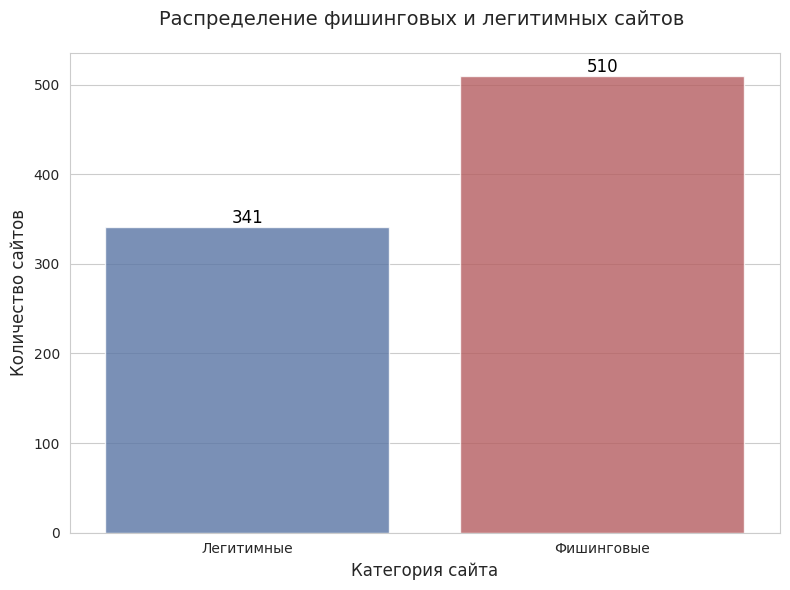

In [89]:

# Подсчет количества фишинговых и легитимных сайтов
counts = df['Label'].value_counts()

# Создание DataFrame для визуализации
df_counts = pd.DataFrame({
    'Тип сайта': ['Легитимные', 'Фишинговые'],
    'Количество': [counts.get(0, 0), counts.get(1, 0)]
})

# Создание столбчатой диаграммы
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
bar_plot = sns.barplot(x='Тип сайта', y='Количество', data=df_counts, 
                       palette=['#4c72b0', '#c44e52'], alpha=0.8)

# Добавление подписей
plt.title('Распределение фишинговых и легитимных сайтов ', fontsize=14, pad=20)
plt.xlabel('Категория сайта', fontsize=12)
plt.ylabel('Количество сайтов', fontsize=12)

# Добавление значений над столбцами
for index, row in df_counts.iterrows():
    bar_plot.text(index, row['Количество'], f"{row['Количество']}", 
                 color='black', ha="center", va="bottom", fontsize=12)

# Показ диаграммы
plt.tight_layout()
plt.show()


In [90]:
# преобразуем текст в последовательности чисел
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_text)
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=500)

# нормализуем числовые признаки
scaler = StandardScaler()
X_numeric = scaler.fit_transform(X_numeric)

# кодируем метки
encoder = LabelEncoder()
y = encoder.fit_transform(y)


In [91]:



# настраиваем кросс-валидцию
n_splits = 10
n_epochs = 70
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Для хранения метрик
all_fold_metrics = {
    'val_f1': np.zeros((n_splits, n_epochs)),
    'val_auc': np.zeros((n_splits, n_epochs)),
    'val_loss': np.zeros((n_splits, n_epochs)),
    'val_precision': np.zeros((n_splits, n_epochs)),
    'val_recall': np.zeros((n_splits, n_epochs)),
    'val_pr_auc': np.zeros((n_splits, n_epochs))
}

# Для хранения финальных метрик на тестовых данных
test_metrics = {
    'f1': [],
    'roc_auc': [],
    'precision': [],
    'recall': [],
    'pr_auc': [],
    'confusion_matrix': [],
    'roc_curve': [],
    'pr_curve': []
}

# Кастомный callback для сохранения метрик
class FoldMetricsLogger(Callback):
    def __init__(self, fold_idx, val_data):
        super().__init__()
        self.fold_idx = fold_idx
        self.val_data = val_data
    
    def on_epoch_end(self, epoch, logs=None):
        X_val_text, X_val_num, y_val = self.val_data
        y_pred = self.model.predict([X_val_text, X_val_num], verbose=0)
        y_pred_classes = (y_pred > 0.5).astype(int)
        
        all_fold_metrics['val_f1'][self.fold_idx, epoch] = f1_score(y_val, y_pred_classes)
        all_fold_metrics['val_auc'][self.fold_idx, epoch] = roc_auc_score(y_val, y_pred)
        all_fold_metrics['val_loss'][self.fold_idx, epoch] = logs['val_loss']
        all_fold_metrics['val_precision'][self.fold_idx, epoch] = precision_score(y_val, y_pred_classes)
        all_fold_metrics['val_recall'][self.fold_idx, epoch] = recall_score(y_val, y_pred_classes)
        
        precision, recall, _ = precision_recall_curve(y_val, y_pred)
        all_fold_metrics['val_pr_auc'][self.fold_idx, epoch] = auc(recall, precision)


In [92]:

# Функция создания модели
def create_model():
    # Вход для текста
    text_input = Input(shape=(500,), name='text_input')
    embedding = Embedding(input_dim=40000, output_dim=256)(text_input) #30000 128
    conv1 = Conv1D(32, 4, activation='relu')(embedding) #128 5
    pool1 = MaxPooling1D(3)(conv1) #5
    conv2 = Conv1D(32, 4, activation='relu')(pool1) #128 5
    pool2 = MaxPooling1D(3)(conv2) #5
    lstm = Bidirectional(LSTM(128))(pool2) #256
     
    
    # Вход для числовых признаков
    num_input = Input(shape=(X_numeric.shape[1],), name='num_input')
    dense_num = Dense(128, activation='relu')(num_input)
    
    # Объединение
    merged = concatenate([lstm, dense_num])
    dropout = Dropout(0.2)(merged)
    dense1 = Dense(32, activation='relu', kernel_regularizer=l2(0.08))(dropout) #0.03
    output = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=[text_input, num_input], outputs=output)
    
    optimizer = AdamW(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [93]:

# Кросс-валидация
for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X_pad, y)):
    print(f"\n{'='*50}\nFold {fold_idx + 1}\n{'='*50}")
    
    # Подготовка данных
    X_train_text, X_val_text = X_pad[train_idx], X_pad[val_idx]
    X_train_num, X_val_num = X_numeric[train_idx], X_numeric[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    # Балансировка классов
    class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y_train)
    class_weights = dict(enumerate(class_weights))
    
    # Создание модели
    model = create_model()
    
    # Callbacks
    metrics_logger = FoldMetricsLogger(fold_idx, (X_val_text, X_val_num, y_val))
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
    
    # Обучение
    history = model.fit(
        [X_train_text, X_train_num], y_train,
        epochs=n_epochs,
        batch_size=64,
        validation_data=([X_val_text, X_val_num], y_val),
        callbacks=[metrics_logger, early_stopping, reduce_lr],
        class_weight=class_weights,
        verbose=1
    )


Fold 1
Epoch 1/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.6375 - loss: 5.3894 - val_accuracy: 0.7093 - val_loss: 5.2686 - learning_rate: 1.0000e-04
Epoch 2/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7398 - loss: 5.2191 - val_accuracy: 0.8256 - val_loss: 5.1121 - learning_rate: 1.0000e-04
Epoch 3/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7856 - loss: 5.0800 - val_accuracy: 0.8256 - val_loss: 4.9523 - learning_rate: 1.0000e-04
Epoch 4/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8370 - loss: 4.9157 - val_accuracy: 0.7791 - val_loss: 4.7785 - learning_rate: 1.0000e-04
Epoch 5/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8134 - loss: 4.7389 - val_accuracy: 0.7791 - val_loss: 4.5898 - learning_rate: 1.0000e-04
Epoch 6/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8086 - loss: 4.5527 - val_accuracy: 0.7907 - val_loss: 4.4224 - learning_rate: 1.0000e-04
Epoch 7/70
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy

In [94]:
 # Сохранение метрик на тестовых данных для лучшей эпохи
y_pred = model.predict([X_val_text, X_val_num])
y_pred_classes = (y_pred > 0.5).astype(int)

test_metrics['f1'].append(f1_score(y_val, y_pred_classes))
test_metrics['roc_auc'].append(roc_auc_score(y_val, y_pred))
test_metrics['precision'].append(precision_score(y_val, y_pred_classes))
test_metrics['recall'].append(recall_score(y_val, y_pred_classes))

precision, recall, _ = precision_recall_curve(y_val, y_pred)
test_metrics['pr_auc'].append(auc(recall, precision))
test_metrics['confusion_matrix'].append(confusion_matrix(y_val, y_pred_classes))

# ROC curve data
fpr, tpr, _ = roc_curve(y_val, y_pred)
test_metrics['roc_curve'].append((fpr, tpr))

# PR curve data
precision, recall, _ = precision_recall_curve(y_val, y_pred)
test_metrics['pr_curve'].append((precision, recall))


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [95]:
print("\nОбучим финальную модель на всех данных с лучшим количеством эпох")

# Анализ результатов кросс-валидации
mean_f1_per_epoch = np.mean(all_fold_metrics['val_f1'], axis=0)
mean_auc_per_epoch = np.mean(all_fold_metrics['val_auc'], axis=0)
mean_loss_per_epoch = np.mean(all_fold_metrics['val_loss'], axis=0)
mean_precision_per_epoch = np.mean(all_fold_metrics['val_precision'], axis=0)
mean_recall_per_epoch = np.mean(all_fold_metrics['val_recall'], axis=0)
mean_pr_auc_per_epoch = np.mean(all_fold_metrics['val_pr_auc'], axis=0)

best_epoch = np.argmax(mean_f1_per_epoch)
best_f1 = mean_f1_per_epoch[best_epoch]
best_auc = mean_auc_per_epoch[best_epoch]
best_precision = mean_precision_per_epoch[best_epoch]
best_recall = mean_recall_per_epoch[best_epoch]


print(f"\nЛучшая эпоха: {best_epoch + 1}")
print(f"Средний F1-score по всем фолдам: {best_f1:.4f}")
print(f"Средний ROC AUC по всем фолдам: {best_auc:.4f}") 
print(f"Средняя точность (Precision) по всем фолдам: {best_precision:.4f}")
print(f"Средняя полнота (Recall) по всем фолдам: {best_recall:.4f}")




Обучим финальную модель на всех данных с лучшим количеством эпох

Лучшая эпоха: 53
Средний F1-score по всем фолдам: 0.9373
Средний ROC AUC по всем фолдам: 0.9736
Средняя точность (Precision) по всем фолдам: 0.9329
Средняя полнота (Recall) по всем фолдам: 0.9431


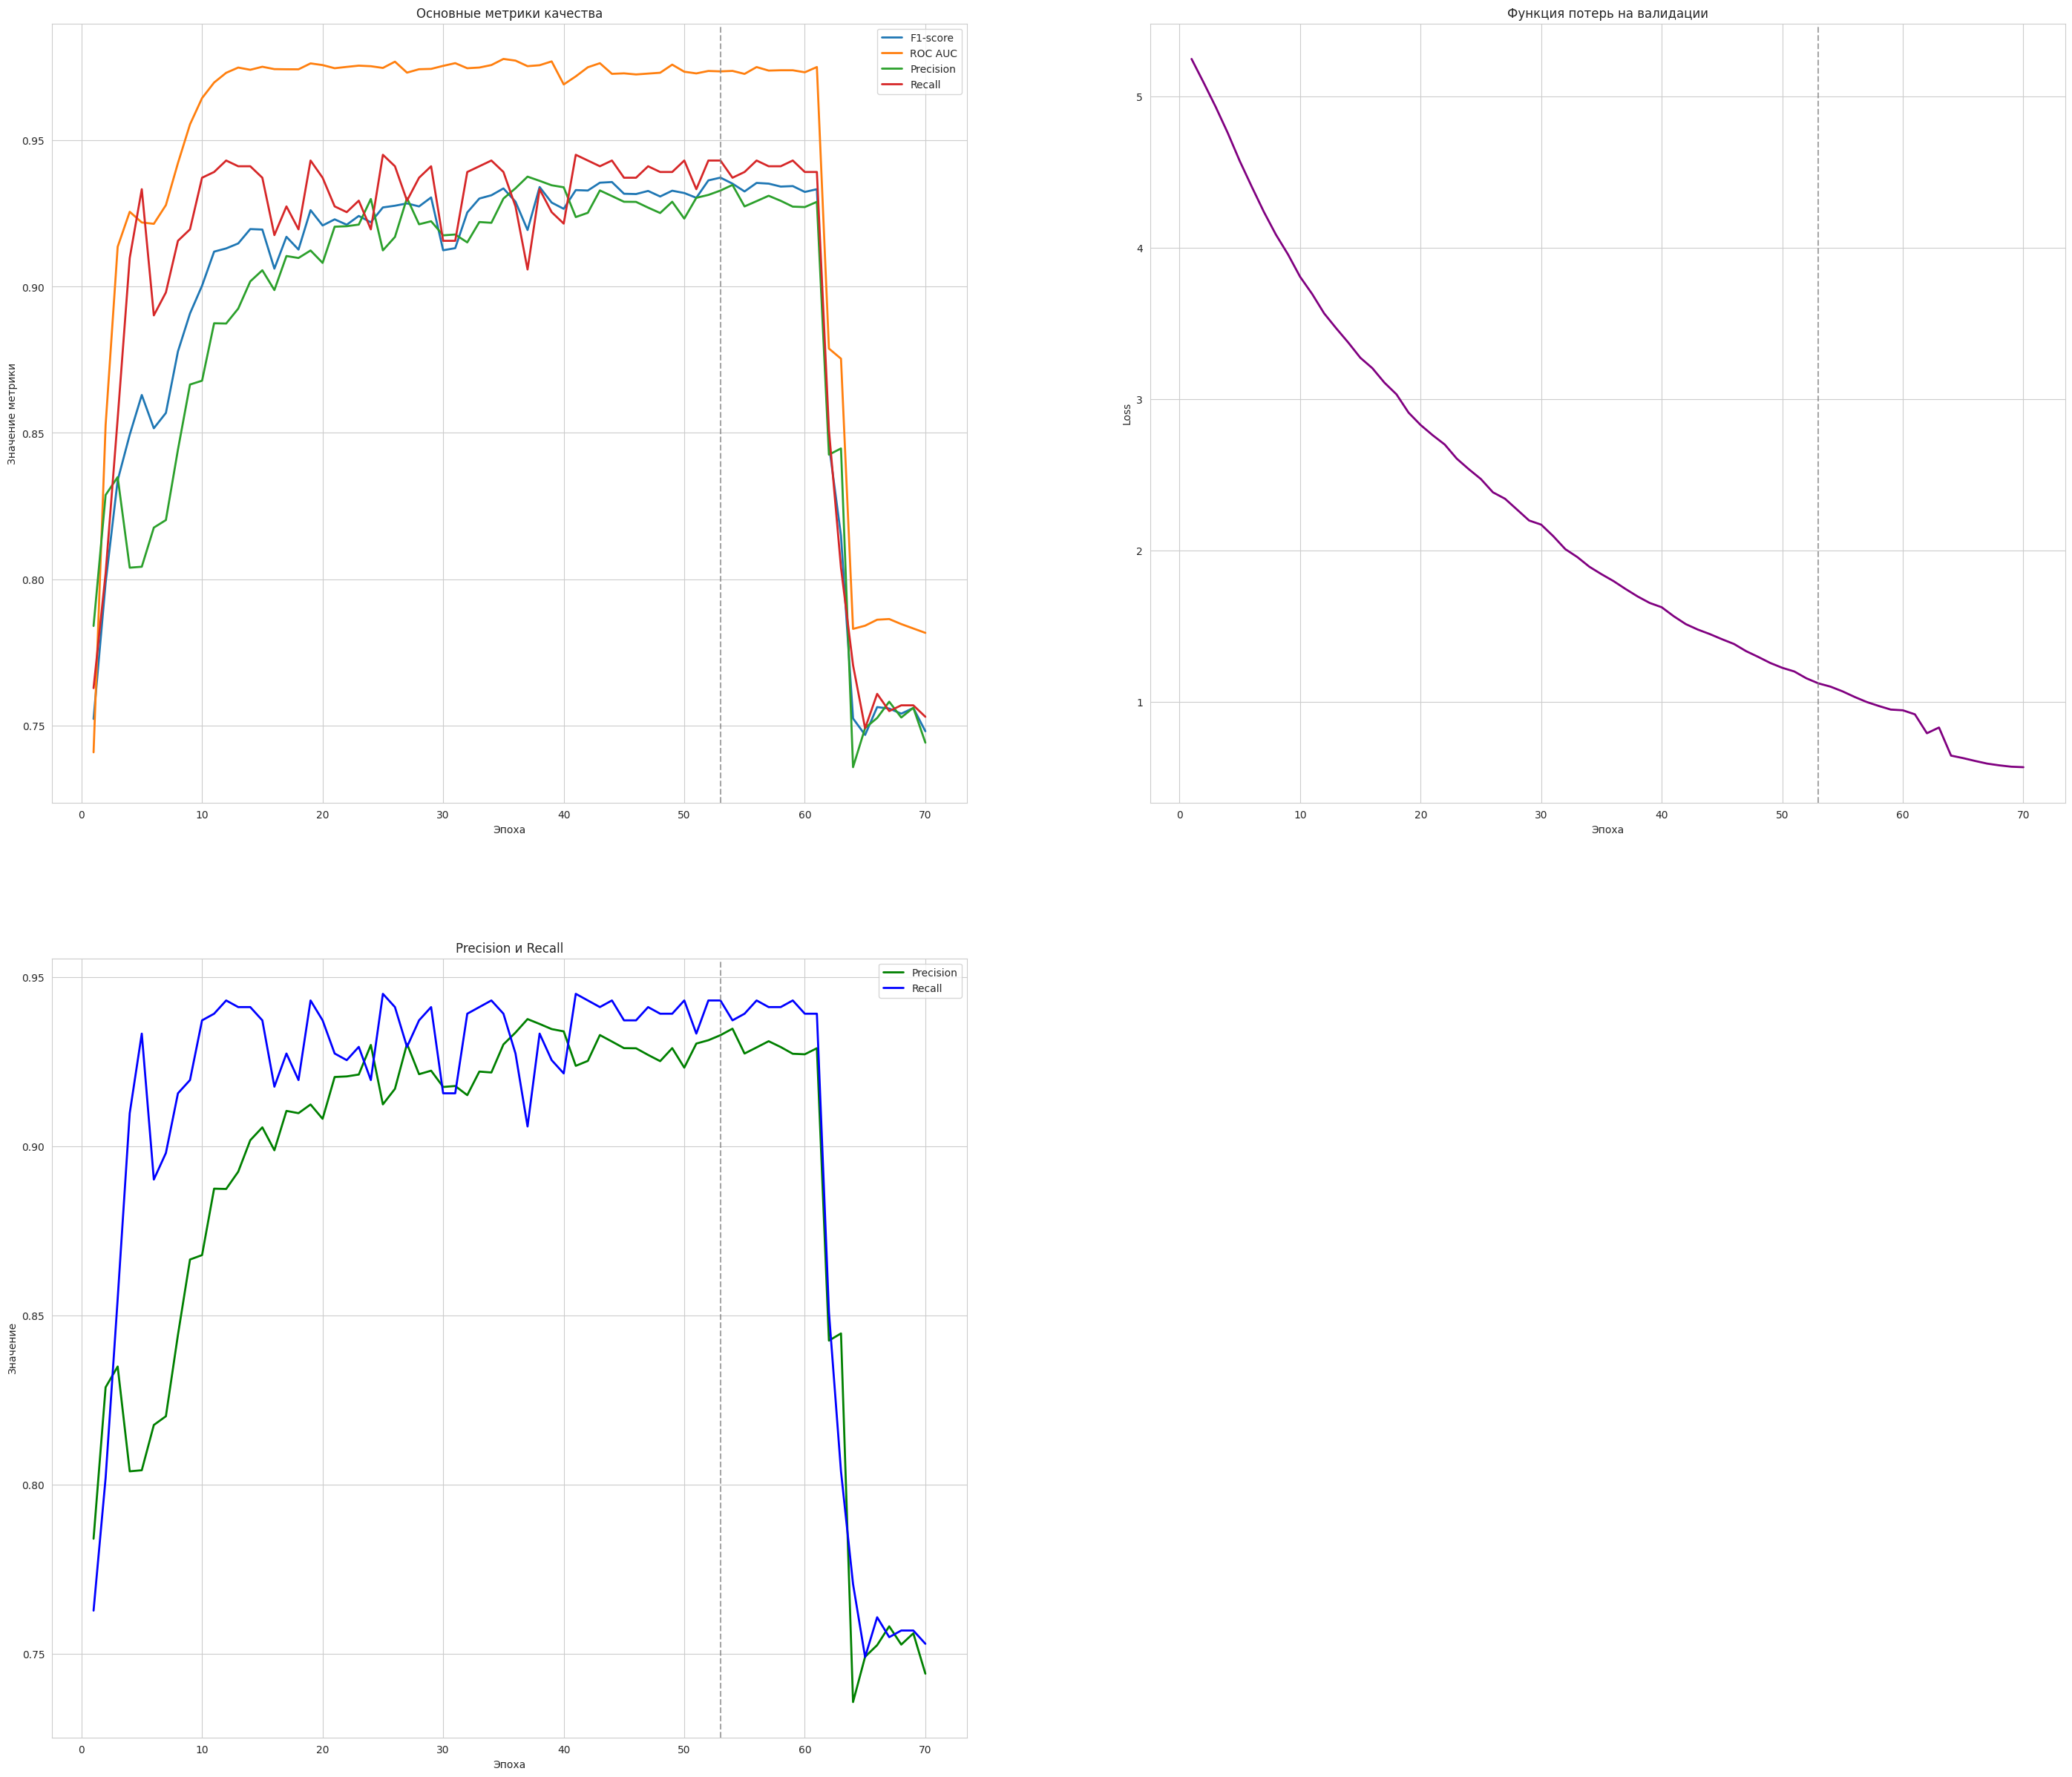

In [96]:
# Создаем фигуру с несколькими графиками
plt.figure(figsize=(35, 30))
epochs = np.arange(1, len(mean_f1_per_epoch)+1)
metrics = {
    'F1-score': mean_f1_per_epoch,
    'ROC AUC': mean_auc_per_epoch,
    'Precision': mean_precision_per_epoch,
    'Recall': mean_recall_per_epoch,
    'PR AUC': mean_pr_auc_per_epoch,
    'Loss': mean_loss_per_epoch
}
# График 1: Основные метрики качества
plt.subplot(2, 2, 1)
for name, values in metrics.items():
    if name not in ['Loss', 'PR AUC']:
        plt.plot(epochs, values, label=name, linewidth=2)
plt.axvline(x=best_epoch+1, color='gray', linestyle='--', alpha=0.7)
plt.title('Основные метрики качества')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid(True)

# График 2: Функция потерь
plt.subplot(2, 2, 2)
plt.plot(epochs, metrics['Loss'], color='purple', linewidth=2)
plt.axvline(x=best_epoch+1, color='gray', linestyle='--', alpha=0.7)
plt.title('Функция потерь на валидации')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.grid(True)

# График 3: Precision-Recall
plt.subplot(2, 2, 3)
plt.plot(epochs, metrics['Precision'], label='Precision', color='green', linewidth=2)
plt.plot(epochs, metrics['Recall'], label='Recall', color='blue', linewidth=2)
plt.axvline(x=best_epoch+1, color='gray', linestyle='--', alpha=0.7)
plt.title('Precision и Recall')
plt.xlabel('Эпоха')
plt.ylabel('Значение')
plt.legend()
plt.grid(True)

In [97]:

print("\nОбучим финальную модель на всех данных с лучшим количеством эпох")

# Балансировка классов для всех данных
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = dict(enumerate(class_weights))

# Создание и обучение финальной модели
final_model = create_model()
final_model.fit(
    [X_pad, X_numeric], y,
    epochs=best_epoch+1,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)


Обучим финальную модель на всех данных с лучшим количеством эпох
Epoch 1/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.6465 - loss: 5.3318
Epoch 2/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7605 - loss: 4.9928
Epoch 3/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8128 - loss: 4.6629
Epoch 4/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8264 - loss: 4.2771
Epoch 5/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8532 - loss: 3.9464
Epoch 6/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8901 - loss: 3.6275
Epoch 7/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9246 - loss: 3.3583
Epoch 8/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9233 - loss: 3.1546
Epoch 9/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9292 - loss: 2.9290
Epoch 10/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9509 - loss: 2.7213
Epoch 11/53
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9442 - loss: 2.53

Успешно завершено фолдов: 1


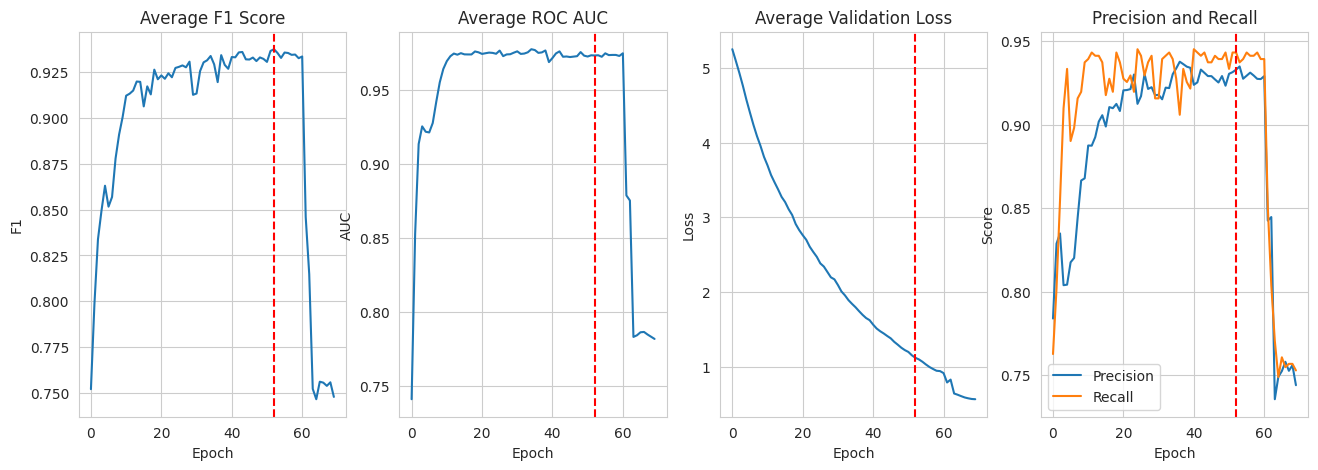

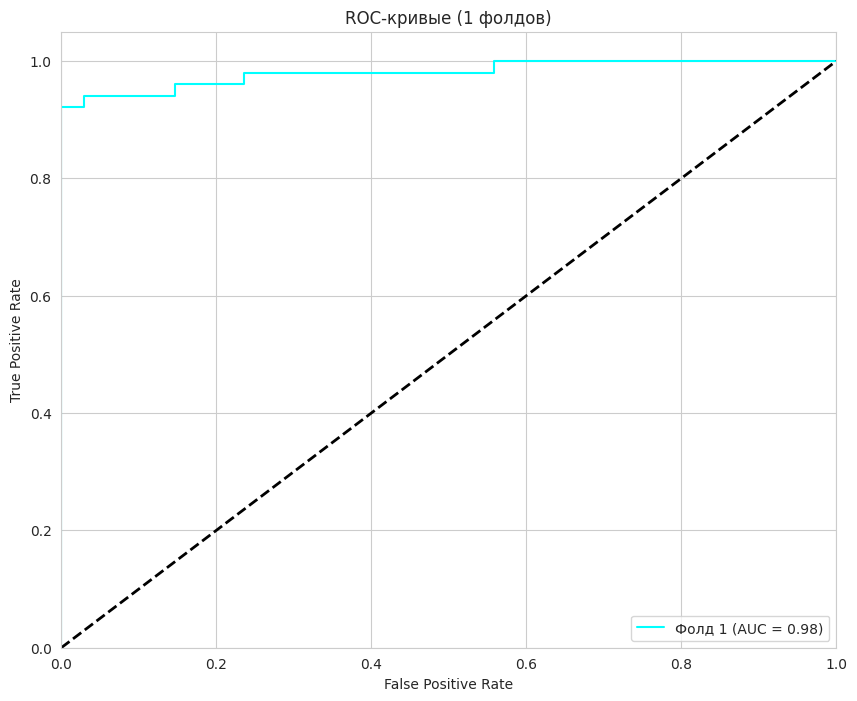

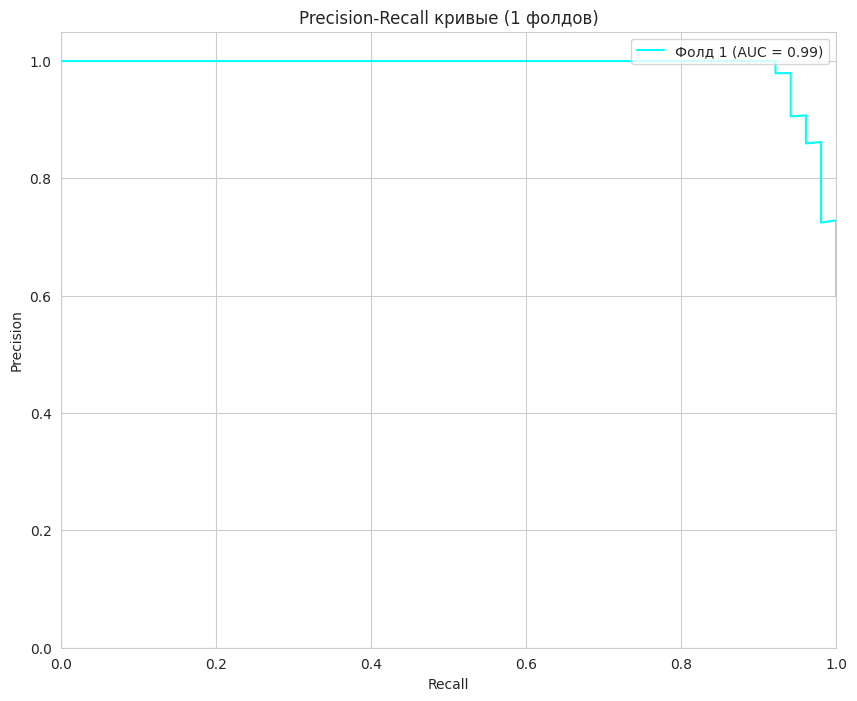

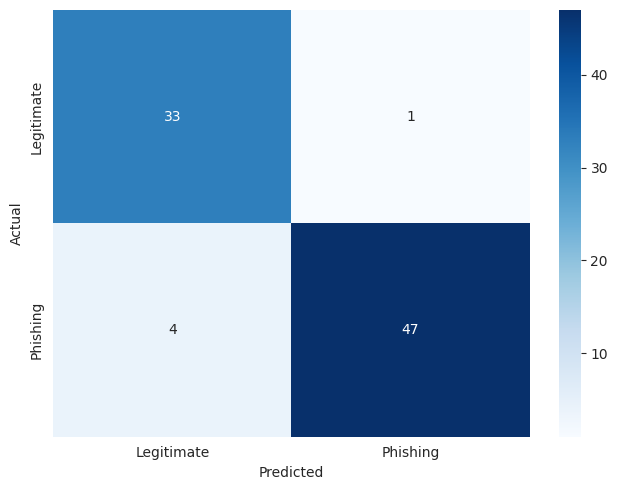


Classification reports for each fold:

Fold 1:
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
              precision    recall  f1-score   support

  Legitimate       1.00      0.97      0.99        34
    Phishing       0.98      1.00      0.99        51

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85



In [201]:
# 1. Сначала убедимся, что все метрики имеют одинаковую длину
completed_folds = len(test_metrics['roc_curve'])
print(f"Успешно завершено фолдов: {completed_folds}")

# 2. Графики средних метрик по эпохам
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.plot(mean_f1_per_epoch)
plt.axvline(best_epoch, color='r', linestyle='--')
plt.title('Average F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')

plt.subplot(1, 5, 2)
plt.plot(mean_auc_per_epoch)
plt.axvline(best_epoch, color='r', linestyle='--')
plt.title('Average ROC AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.subplot(1, 5, 3)
plt.plot(mean_loss_per_epoch)
plt.axvline(best_epoch, color='r', linestyle='--')
plt.title('Average Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 5, 4)
plt.plot(mean_precision_per_epoch, label='Precision')
plt.plot(mean_recall_per_epoch, label='Recall')
plt.axvline(best_epoch, color='r', linestyle='--')
plt.title('Precision and Recall')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()


# 3. ROC-кривые только для завершенных фолдов
if completed_folds > 0:
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 
              'purple', 'pink', 'brown', 'gray', 'olive']
    
    for i in range(completed_folds):
        fpr, tpr = test_metrics['roc_curve'][i]
        plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=1.5,
                 label=f'Фолд {i+1} (AUC = {test_metrics["roc_auc"][i]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-кривые ({completed_folds} фолдов)')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("Нет данных для построения ROC-кривых")

# 4. Precision-Recall кривые
if completed_folds > 0:
    plt.figure(figsize=(10, 8))
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 
              'purple', 'pink', 'brown', 'gray', 'olive']
    
    for i in range(completed_folds):
        precision, recall = test_metrics['pr_curve'][i]
        plt.plot(recall, precision, color=colors[i % len(colors)], lw=1.5,
                 label=f'Фолд {i+1} (AUC = {test_metrics["pr_auc"][i]:.2f})')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall кривые ({completed_folds} фолдов)')
    plt.legend(loc="upper right")
    plt.show()
else:
    print("Нет данных для построения Precision-Recall кривых")

# 5. Confusion matrix
if completed_folds > 0:
    plt.figure(figsize=(25, 5))
    rows = (completed_folds + 3) // 4  # Вычисляем нужное количество строк
    for i in range(completed_folds):
        plt.subplot(rows, 4, i+1)
        cm = test_metrics['confusion_matrix'][i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Legitimate', 'Phishing'], 
                    yticklabels=['Legitimate', 'Phishing'])
        plt.title(f'')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для построения матриц ошибок")

# 6. Classification reports
if completed_folds > 0:
    print("\nClassification reports for each fold:")
    for i in range(completed_folds):
        print(f"\nFold {i+1}:")
        y_pred = (model.predict([X_pad[val_idx], X_numeric[val_idx]]) > 0.5).astype(int)
        print(classification_report(y[val_idx], y_pred, target_names=['Legitimate', 'Phishing']))
else:
    print("Нет данных для classification reports")

In [99]:
model.save('myphish_model.h5') 

In [100]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc




In [151]:

# Загрузка обученной модели
model = load_model('/kaggle/input/bestmodel/tensorflow2/default/1/2best_phishing_detection_model.h5')

# Загрузка тестового датасета
test_df = pd.read_csv('/kaggle/input/tds-fi-site/updated_test_dataset31-05-25.csv', sep="\t")

# Подготовка данных (так же как при обучении)
X_text_test = test_df['Text Content'].values
X_numeric_test = test_df[['url_length', 'num_subdomains', 'has_hyphen',
                         'has_https', 'domain_length', 'phishing_keywords_in_url',
                         'phishing_keywords_in_text', 'text_length']].values
y_test = test_df['Label'].values

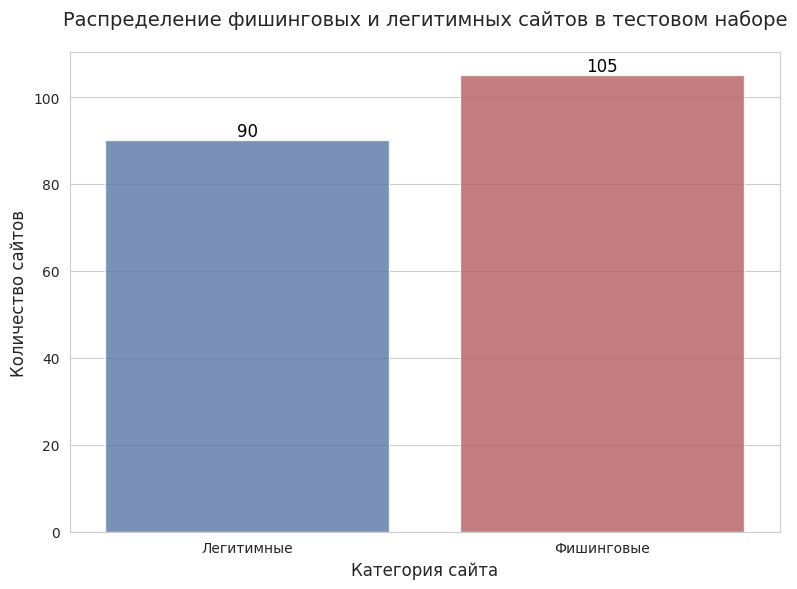

In [153]:
counts = test_df['Label'].value_counts()

# Создание DataFrame для визуализации
df_counts = pd.DataFrame({
    'Тип сайта': ['Легитимные', 'Фишинговые'],
    'Количество': [counts.get(0, 0), counts.get(1, 0)]
})

# Создание столбчатой диаграммы
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
bar_plot = sns.barplot(x='Тип сайта', y='Количество', data=df_counts, 
                       palette=['#4c72b0', '#c44e52'], alpha=0.8)

# Добавление подписей
plt.title('Распределение фишинговых и легитимных сайтов в тестовом наборе', fontsize=14, pad=20)
plt.xlabel('Категория сайта', fontsize=12)
plt.ylabel('Количество сайтов', fontsize=12)

# Добавление значений над столбцами
for index, row in df_counts.iterrows():
    bar_plot.text(index, row['Количество'], f"{row['Количество']}", 
                 color='black', ha="center", va="bottom", fontsize=12)

# Показ диаграммы
plt.tight_layout()
plt.show()

In [155]:
# Преобразуем текст в последовательности чисел (используем тот же токенизатор)
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_text_test)
X_seq_test = tokenizer.texts_to_sequences(X_text_test)
X_pad_test = pad_sequences(X_seq_test, maxlen=500)

# Нормализуем числовые признаки (используем тот же scaler)
scaler = StandardScaler()
X_numeric_test = scaler.fit_transform(X_numeric_test)

# Кодируем метки
encoder = LabelEncoder()
y_test_encoded = encoder.fit_transform(y_test)



In [195]:

# Делаем предсказания
y_pred = model.predict([X_pad_test, X_numeric_test])
y_pred_classes = (y_pred > 0.019).astype(int)

# Вычисляем метрики
f1 = f1_score(y_test_encoded, y_pred_classes)
roc_auc = roc_auc_score(y_test_encoded, y_pred)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


In [196]:
# print(y_pred)

In [197]:

# Выводим отчет по классификации
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred_classes, target_names=['Легитимный', 'Фишинг']))
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

  Легитимный       0.81      0.73      0.77        90
      Фишинг       0.79      0.86      0.82       105

    accuracy                           0.80       195
   macro avg       0.80      0.80      0.80       195
weighted avg       0.80      0.80      0.80       195

ROC AUC Score: 0.8232
F1 Score: 0.8219


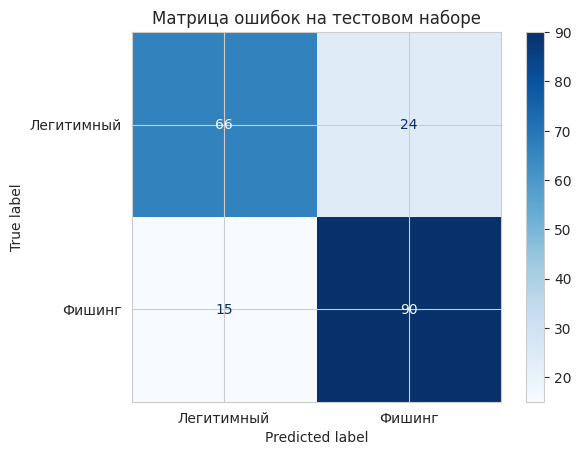

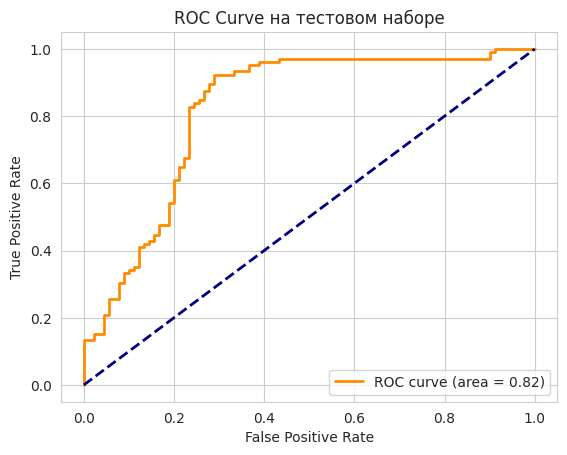

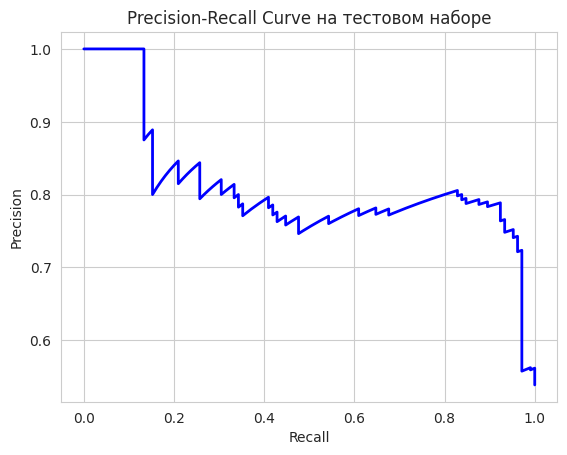

In [198]:


# Визуализация результатов
# Матрица ошибок
cm = confusion_matrix(y_test_encoded, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Легитимный', 'Фишинг'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Матрица ошибок на тестовом наборе')
plt.show()

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve на тестовом наборе')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall кривая
precision, recall, _ = precision_recall_curve(y_test_encoded, y_pred)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve на тестовом наборе')
plt.show()